In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
import colorsys
import imageio as io
from scipy.ndimage import binary_dilation
from skimage.filters import gaussian
from numpy import random
from scipy.stats import skewnorm

In [3]:
def gen_fake_img(imsize,length_var,width_var,rng_wire_bounds,rng_length_loc_scale,fix_length,fix_width):
    #image = np.zeros(( imsize,imsize, 3)) #replace with noise for stability
    image = np.random.normal(loc=0.1,scale=0.05,size=(imsize,imsize,3))
    saturation_map=np.random.normal(loc=0.8,scale=0.2,size=(imsize,imsize))
    saturation_map=gaussian(saturation_map,sigma=3) #introduce long range noise correlations
    hue_map=np.random.normal(loc=0.8,scale=0.2,size=(imsize,imsize))
    hue_map=gaussian(hue_map,sigma=2)
    n_wires=np.random.randint(rng_wire_bounds[0],rng_wire_bounds[1])
    for n in range(n_wires):
        if length_var:
            length=skewnorm.rvs(a=3,loc=rng_length_loc_scale[0],scale=rng_length_loc_scale[1],size=1)
        if not length_var:
            length=np.array([fix_length])

        x_loc = np.array([np.random.rand() * imsize]) 
        y_loc = np.array(np.random.rand() * imsize) 
        angle = np.random.random() * np.pi
        vec_x=np.cos(angle)
        vec_y=np.sin(angle)
        x_wires = (vec_x.reshape(1, 1) * length / 2. * np.linspace(-1, 1, 200) + x_loc.reshape(1,1)).astype(int)
        y_wires = (vec_y.reshape(1, 1) * length / 2. * np.linspace(-1, 1, 200) + y_loc.reshape(1,1)).astype(int)
        indices = (x_wires * imsize + y_wires).flatten() 
        to_rem=np.where(indices>=imsize*imsize)[0] #make sure wire doesnt go out of image
        indices=[indices[i] for i in range(len(indices)) if i not in to_rem]

        wire = np.zeros([imsize*imsize], dtype=np.double)
        wire[indices] = 1
        wire = wire.reshape( imsize, imsize)

        if width_var:
            it=np.random.choice(np.arange(1,6),p=[0.7,0.2,0.07,0.02,0.01])
        if not width_var:
            it=fix_width
        wire = binary_dilation(wire,iterations=it)
        wire=wire.astype(bool)
        image[:,:,0][wire]=angle/np.pi #hue
        image[:,:,1][wire]=hue_map[wire] #saturation
        image[:,:,2][wire]=saturation_map[wire] #brightness
    image=np.clip(image,0,1)
    image=matplotlib.colors.hsv_to_rgb(image) #Better visualization, also probably better use of all 3 channels (hsv varies only little in channel 2 and 3)
    return image

In [4]:
params={'imsize': 256,
        'length_var': True,
        'width_var': True,
        'rng_wire_bounds': [10,40],
        'rng_length_loc_scale': [20,60],
        'fix_length': 50,   
        'fix_width': 1}
N_images=500

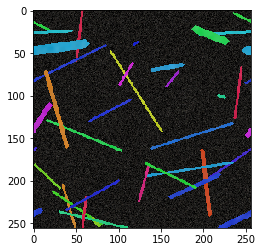

In [5]:
example=gen_fake_img(**params)
plt.imshow(example)

In [ ]:
directory='../Data/Nanowire/Synthetic/'

In [ ]:
for i in range(N_images):
    name=directory+str(i).zfill(5)+'.png'
    image=(gen_fake_img(**params)*255).astype(np.uint8) #map to 0-255,8 bit image
    io.imsave(name,image)
    if i%50==0:
        print(i)